In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# X = np.arange(500).reshape(50, 10) * 1.0

# theta = np.eye(10,10) * 1.0

# def f(theta, X):
#     out = X.dot(theta)
#     return out

# def divergence(f, theta_, X_):

#     def my_div(f_):
#         jac = jax.jacrev(f_, 1)
#         return lambda t, x_: np.trace(jac(t, x_))

#     div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
#     return div
    
# print(divergence(f, theta, X).shape)

In [72]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(100), rng_b = jax.random.PRNGKey(10), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.rng_b = rng_b
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
        self.b_backward_ = jax.vmap(self.b_backward, in_axes=(None, 0))
        self.b_forward_ = jax.vmap(self.b_forward, in_axes=(None, 0))
        
        self.b_backward_s =  lambda theta, x: np.squeeze(self.b_backward(x, theta))
        self.b_forward_s = lambda theta, x: np.squeeze(self.b_forward(x, theta))
        
        self.div_backward_ = jax.vmap(partial(self.divergence, self.b_backward), in_axes=(None, 0))
        self.div_forward_ = jax.vmap(partial(self.divergence, self.b_forward), in_axes=(None, 0))
        
    @staticmethod
    def divergence(f, theta_, X_):

        def my_div(f_):
            jac = jax.jacrev(f_, 1)
            return lambda t, x_: np.trace(jac(t, x_))

        div  = ((jax.vmap(my_div(f), in_axes=(None, 0)) (theta_, X_ )))
        return div
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = self.b_backward_(self.theta_b, Xt)
            b_plus = self.b_forward_(theta, Xt)
            div = self.div_backward_(self.theta_b, Xt)
        else:
            b_minus  = self.b_backward_(theta, Xt)
            b_plus = self.b_forward_(self.theta_f, Xt)
            div = -self.div_forward_(self.theta_f, Xt)
        
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        out =  0.5 * time_integral.sum(axis=(1,2)) - (div.sum(axis=(1)) *  self.dt )

        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta
        )
        Ht = silvermans_rule(Xt[:,-1,:])
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        entropy = 0 #-log_kde_pdf_per_point(Xt[:,-1,:], Xt[:,-1,:], Ht)
        main_term = self.loss_for_trajectory(Xt, theta, W, forwards)

        J = np.mean(main_term + cross_entropy - entropy)
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng_b, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        if plot: self.plot_trajectories()
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, batch_f, True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X, theta: -self.b_backward(X, theta)
        t, Xts = c.sde_solver(
            X0=self.X_0,dt=self.dt,  theta=self.theta_f,
            beta=self.sigma, alfa=self.b_forward, N=self.number_time_steps
        )
        t_, Xts_ = c.sde_solver(
            X0=self.X_1, dt=self.dt,  theta=self.theta_b,
            beta=self.sigma, alfa=bb, N=self.number_time_steps
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.1f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

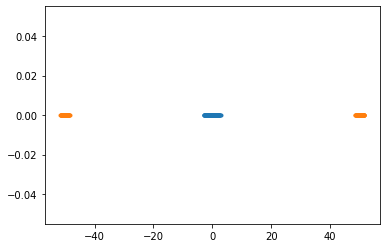

In [73]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) -50
X2 = np.concatenate((X21, X22), axis=0)
X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [77]:
c = cIPFP(X1, X2,  number_time_steps=200, batch_size=500 , step_size = 0.01, weights=[20,20,20,20], rng = jax.random.PRNGKey(100))

In [78]:
# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)


# c.theta_f = c.get_params_f(opt_state_f)
# c.theta_b = c.get_params_f(opt_state_f) 


# c.inner_loss(c.theta_f, next(c.data_stream()), forwards=True);

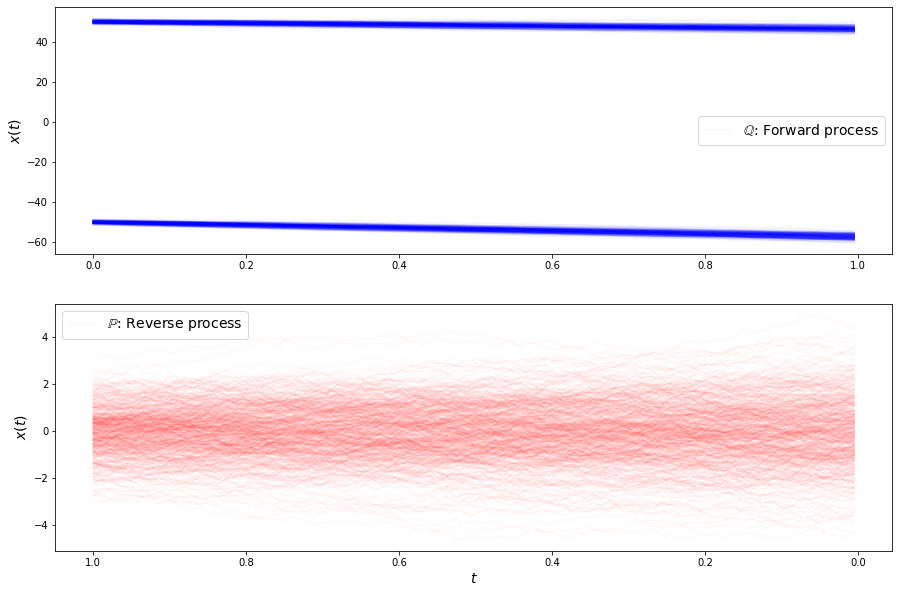

loss b 12.713033676147461
loss b 12.699799537658691
loss b 12.682967185974121
loss f 20723.43359375
loss f 17366.205078125
loss f 14496.7265625


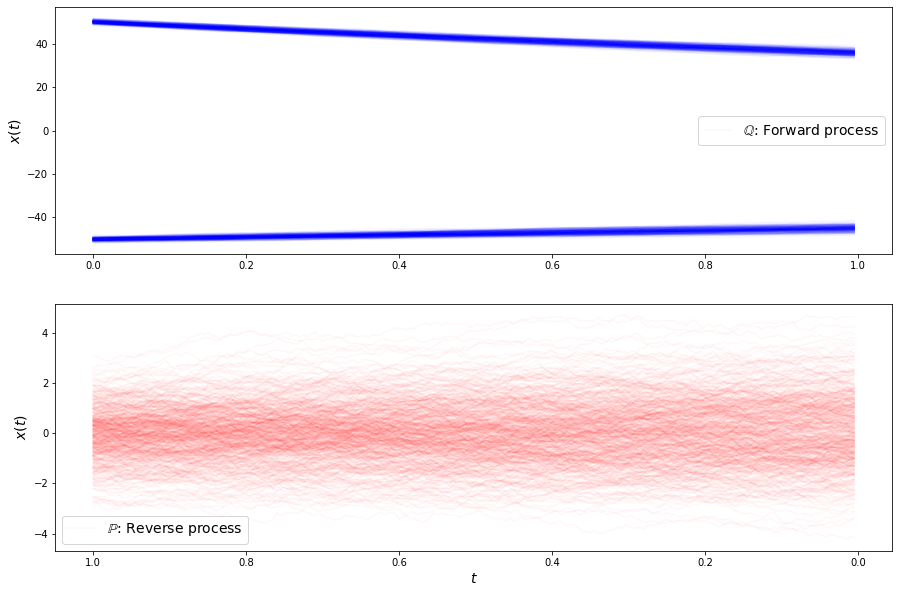

loss b 12.414826393127441
loss b 12.400463104248047
loss b 12.400686264038086
loss f 10336.626953125
loss f 7565.466796875
loss f 5665.19921875


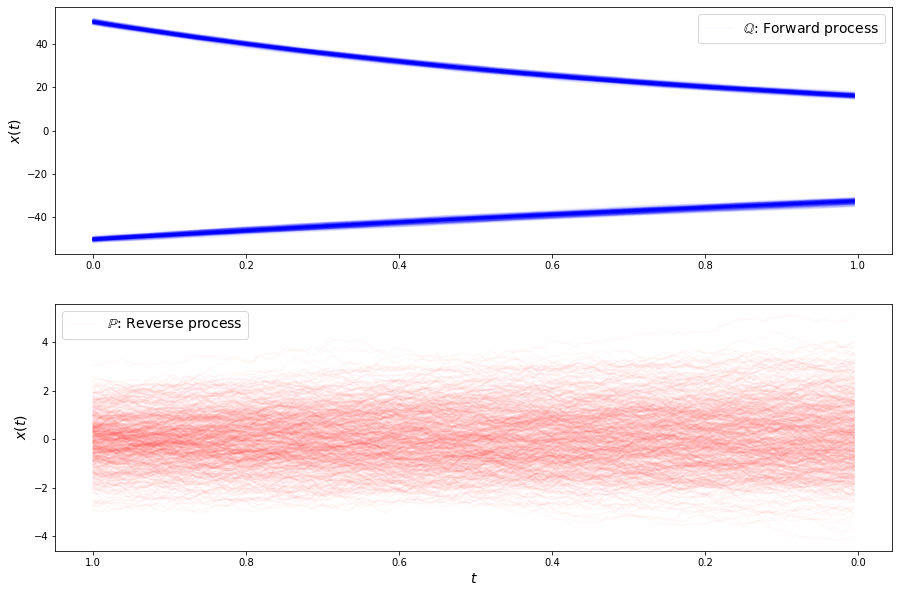

loss b 12.24219799041748
loss b 12.077010154724121
loss b 11.931188583374023
loss f 3148.14208984375
loss f 2173.152587890625
loss f 1666.460205078125


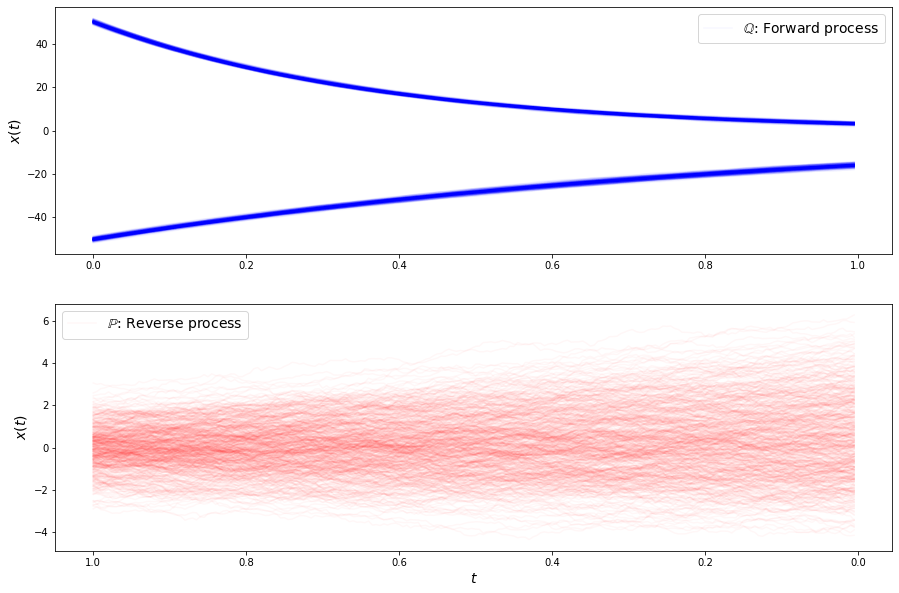

loss b 15.323233604431152
loss b 14.82418155670166
loss b 14.840662956237793
loss f 1062.56494140625
loss f 1028.2501220703125
loss f 1082.376220703125


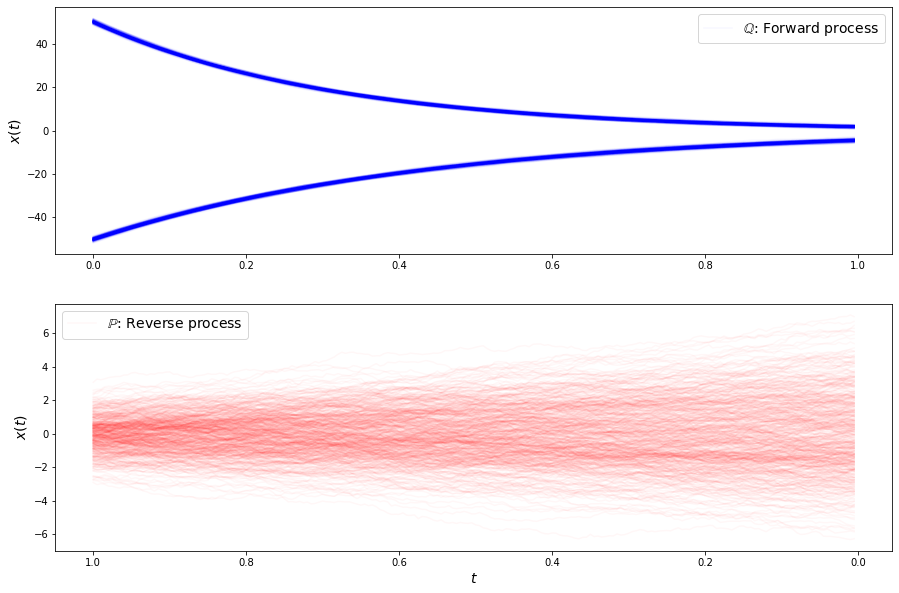

loss b 18.641189575195312
loss b 17.821216583251953
loss b 16.369340896606445
loss f 1138.7139892578125
loss f 1126.98193359375
loss f 1110.4207763671875


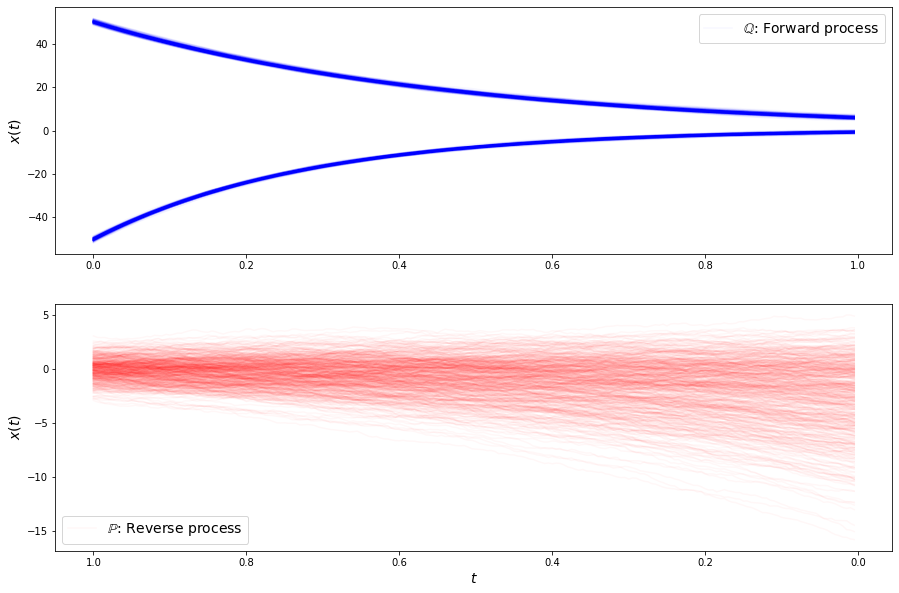

loss b 29.352266311645508
loss b 29.167991638183594
loss b 26.53751564025879
loss f 1886.0379638671875
loss f 1768.315673828125
loss f 1689.3031005859375


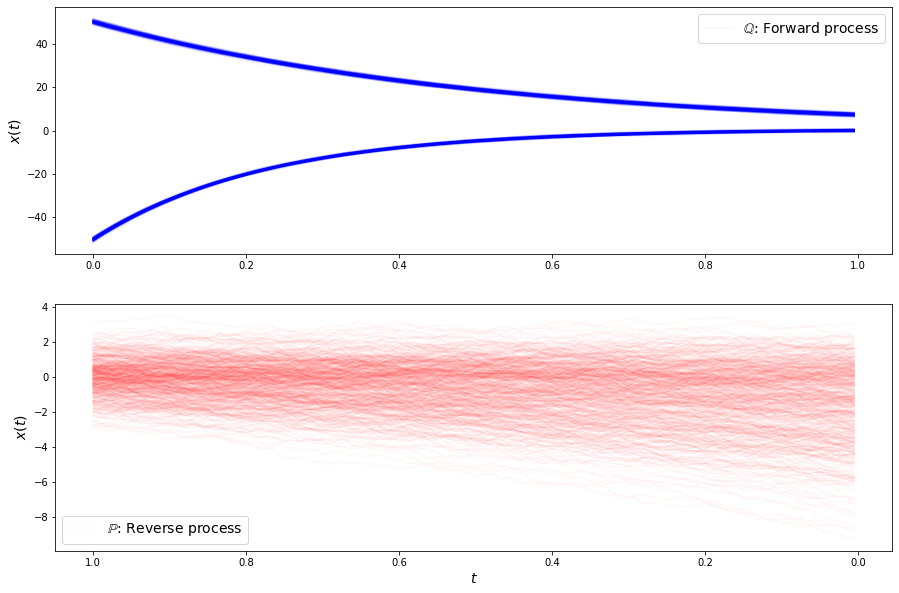

loss b 34.00230407714844
loss b 30.755678176879883
loss b 30.016864776611328
loss f 2145.39892578125
loss f 2253.697998046875
loss f 2289.07275390625


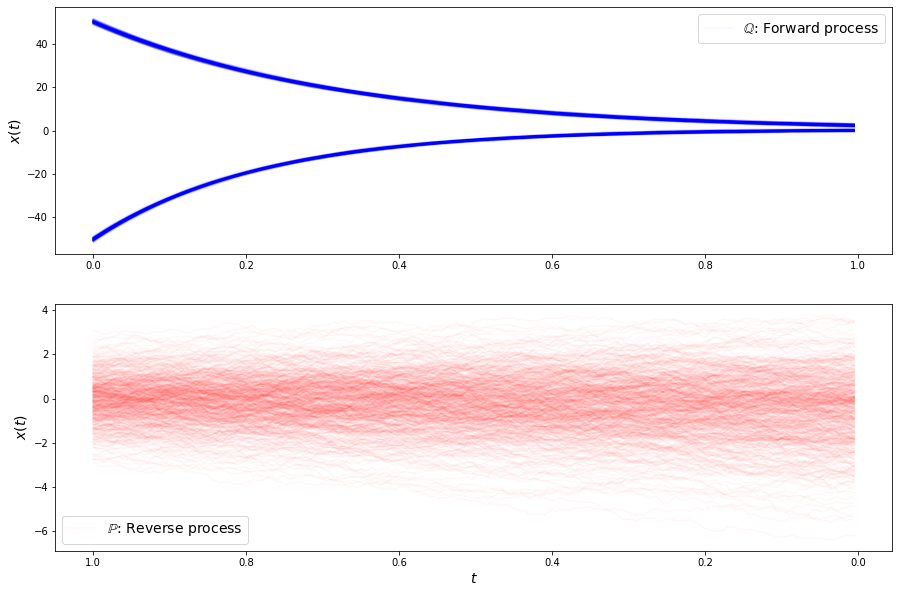

loss b 30.092634201049805
loss b 29.8900203704834
loss b 30.856935501098633
loss f 2377.880126953125
loss f 2281.294677734375
loss f 2166.49267578125


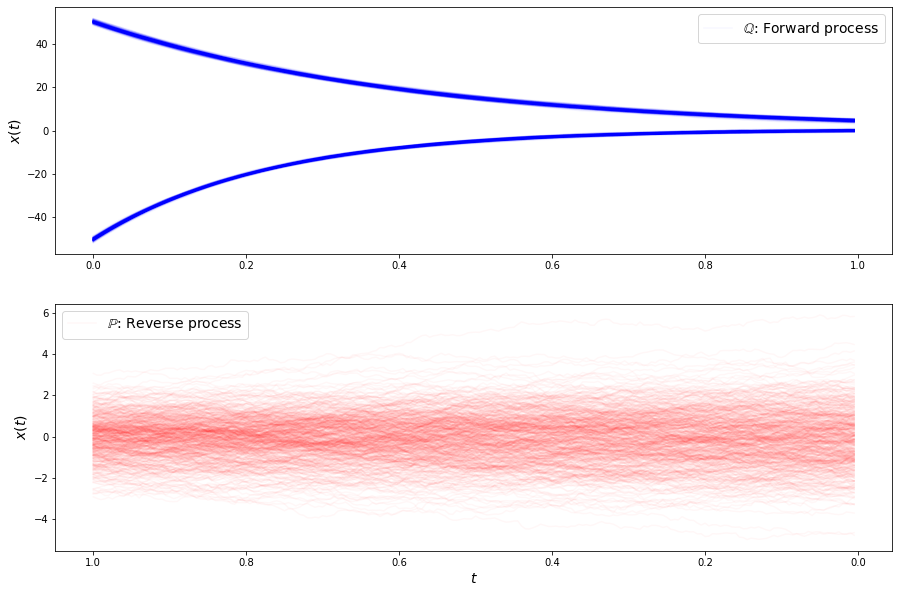

loss b 26.074832916259766
loss b 25.846216201782227
loss b 24.74858856201172
loss f 2077.953857421875
loss f 2123.427490234375
loss f 1995.8095703125


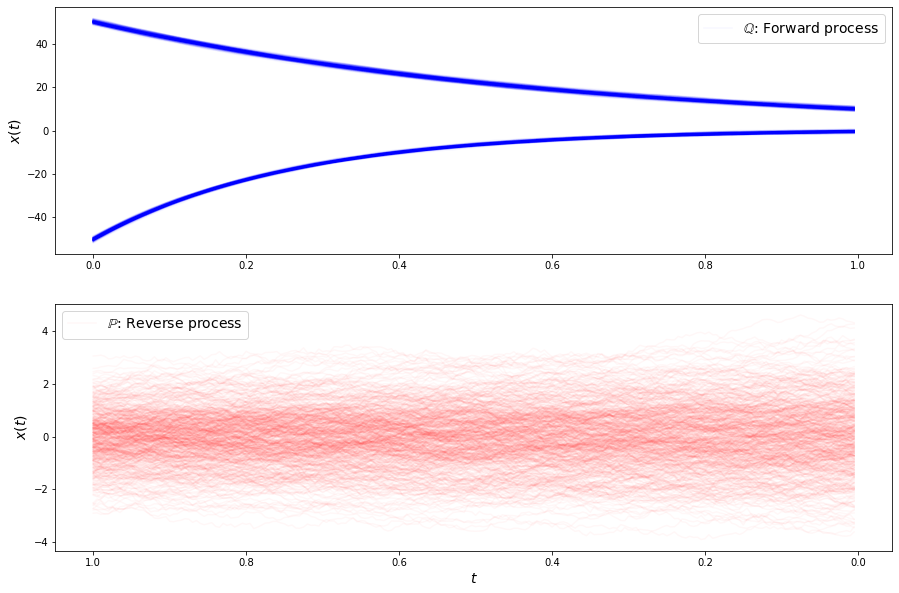

loss b 21.537303924560547
loss b 22.17580795288086
loss b 21.500873565673828
loss f 1844.9254150390625
loss f 1808.20068359375
loss f 1751.6846923828125


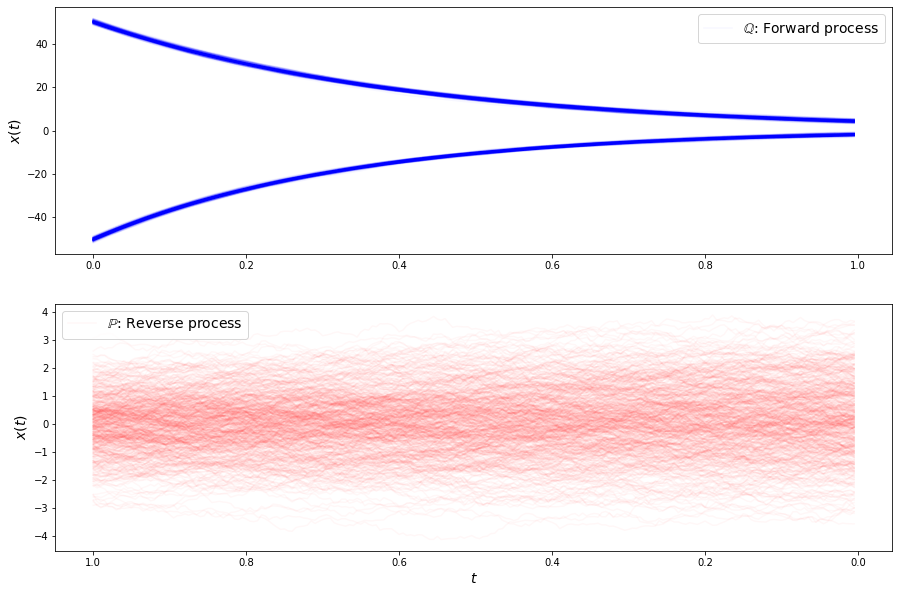

loss b 18.557830810546875
loss b 18.895557403564453
loss b 18.745071411132812
loss f 1601.596923828125
loss f 1476.9014892578125
loss f 1411.1705322265625


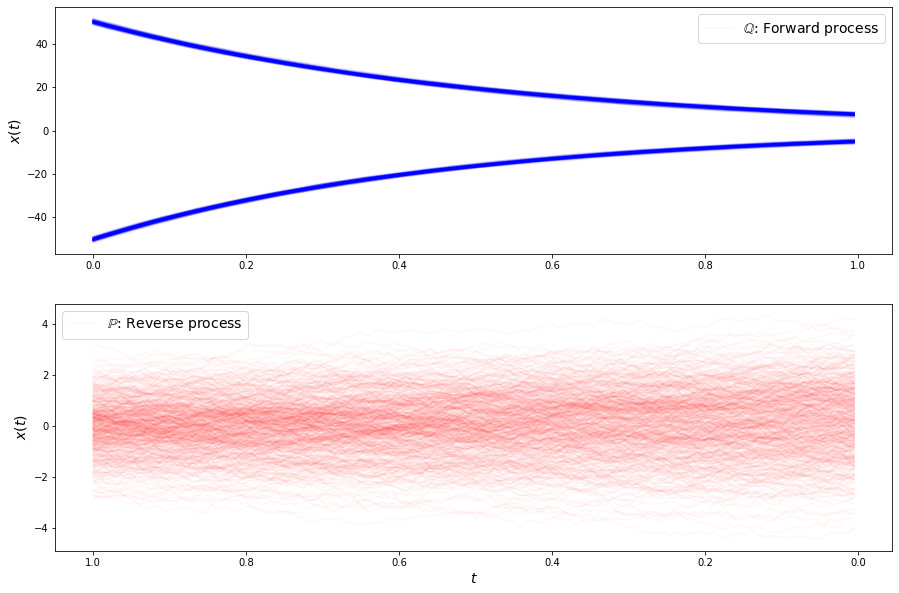

loss b 15.694828033447266
loss b 15.268010139465332
loss b 15.800591468811035
loss f 1415.060791015625
loss f 1443.66748046875
loss f 1470.66259765625


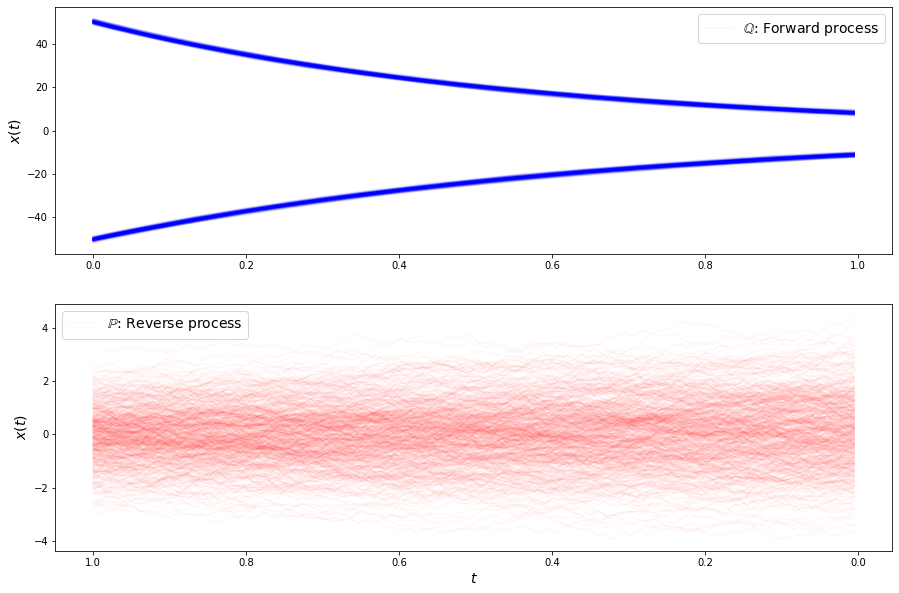

loss b 14.277050018310547
loss b 14.096329689025879
loss b 14.092820167541504
loss f 1518.7352294921875
loss f 1508.5128173828125
loss f 1466.96826171875


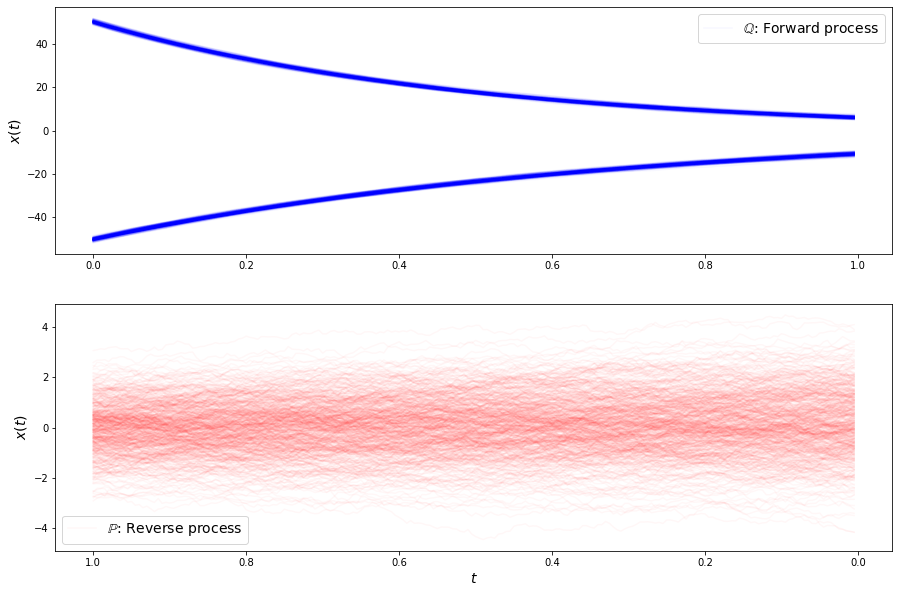

loss b 14.94833755493164
loss b 14.943625450134277
loss b 14.919252395629883
loss f 1384.0242919921875
loss f 1363.550048828125
loss f 1369.8646240234375


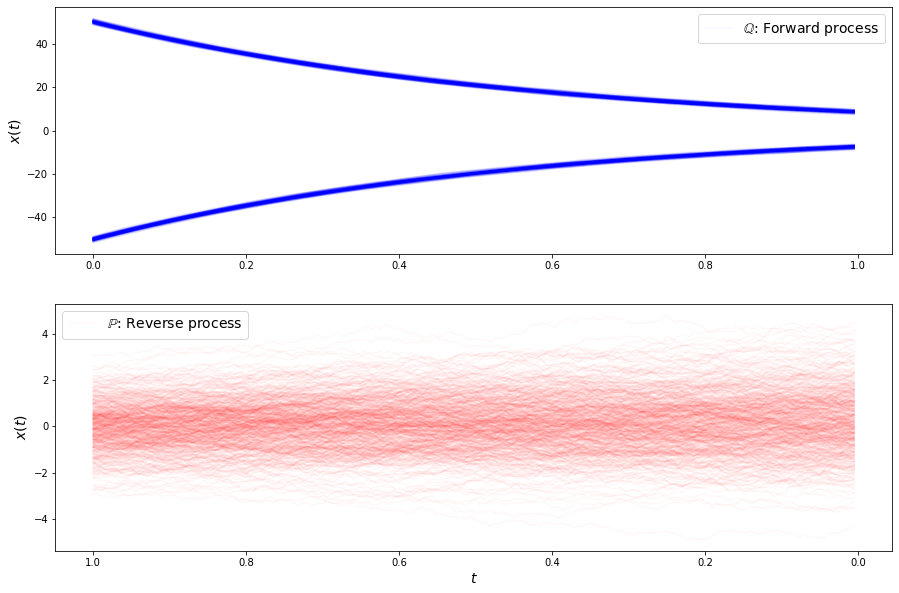

loss b 14.752741813659668
loss b 14.580384254455566
loss b 14.608110427856445
loss f 1366.6441650390625
loss f 1360.866455078125
loss f 1360.7415771484375


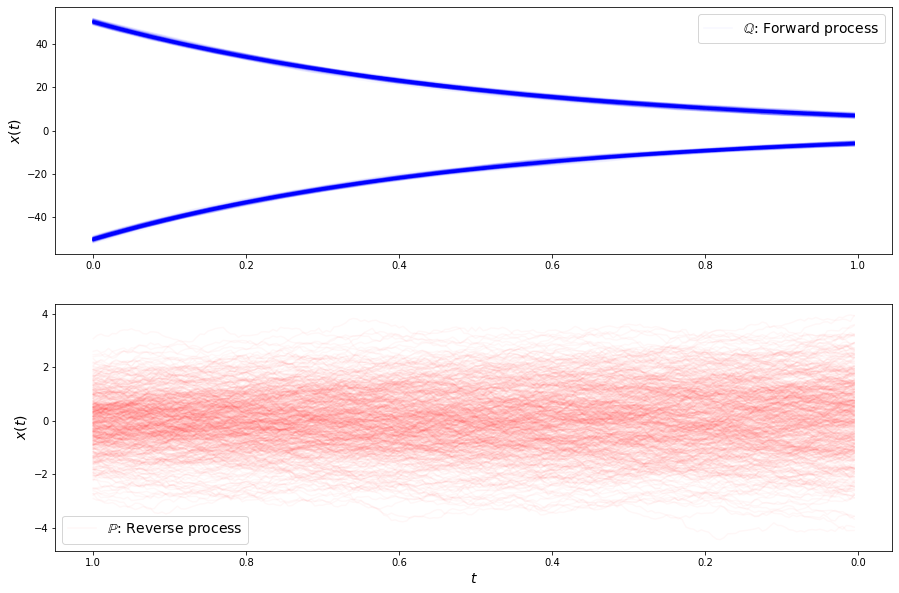

loss b 15.967034339904785
loss b 15.935176849365234
loss b 15.966849327087402
loss f 1377.0537109375
loss f 1377.1507568359375
loss f 1381.5679931640625


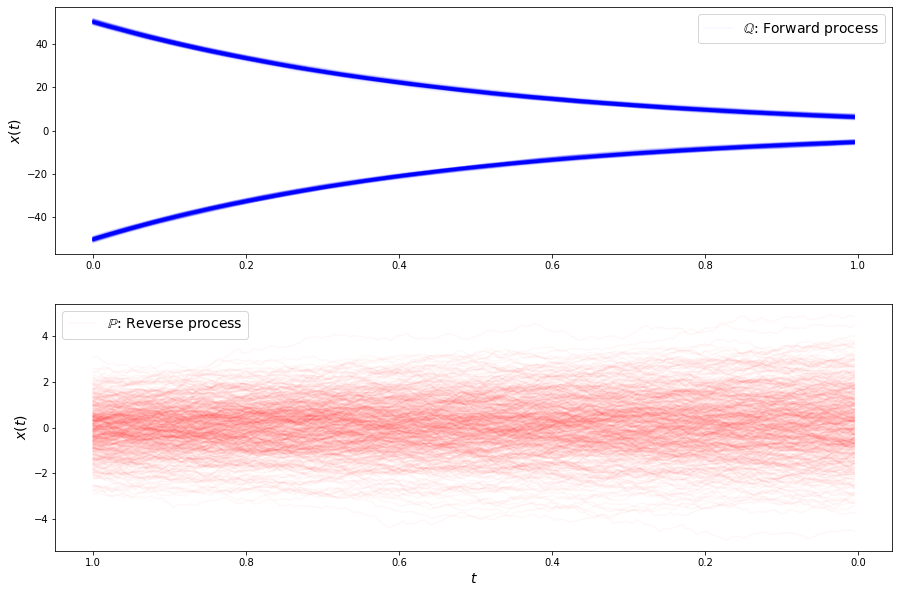

loss b 16.153766632080078
loss b 16.57570457458496
loss b 16.39682388305664
loss f 1368.7275390625
loss f 1359.7862548828125
loss f 1365.07568359375


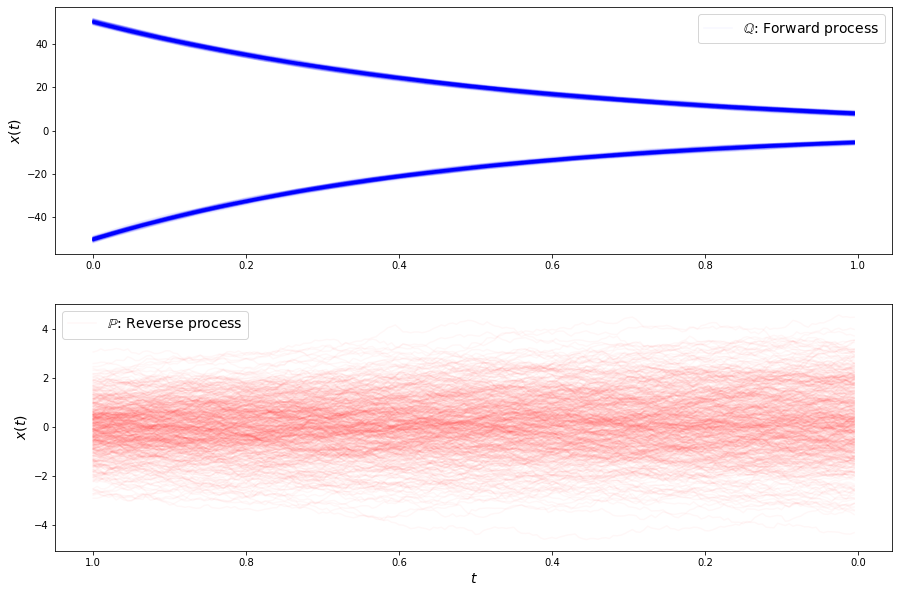

loss b 15.878849983215332
loss b 16.02118682861328
loss b 16.077173233032227
loss f 1343.1968994140625
loss f 1328.812744140625
loss f 1328.21484375


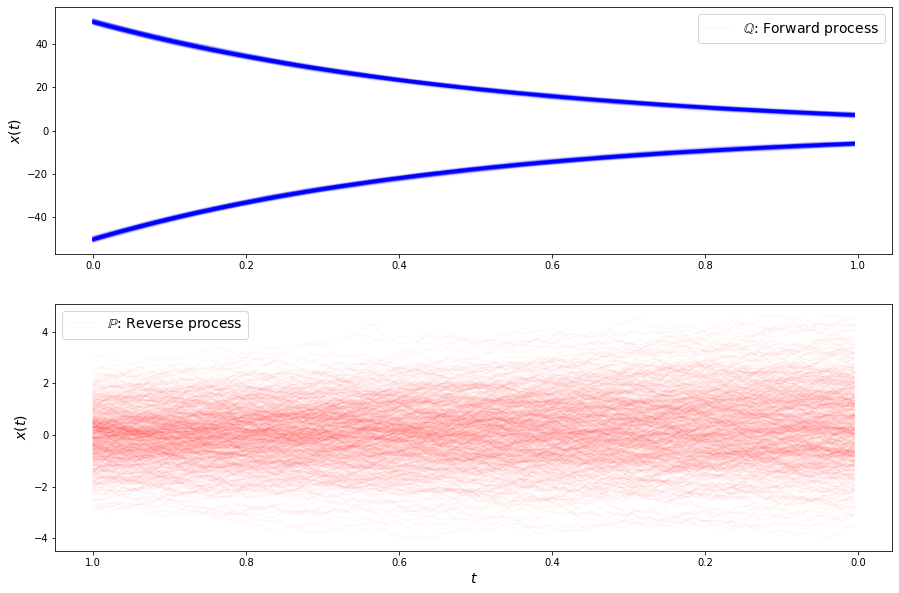

loss b 16.254932403564453
loss b 16.179527282714844
loss b 16.296878814697266
loss f 1297.826416015625
loss f 1298.769287109375
loss f 1295.38818359375


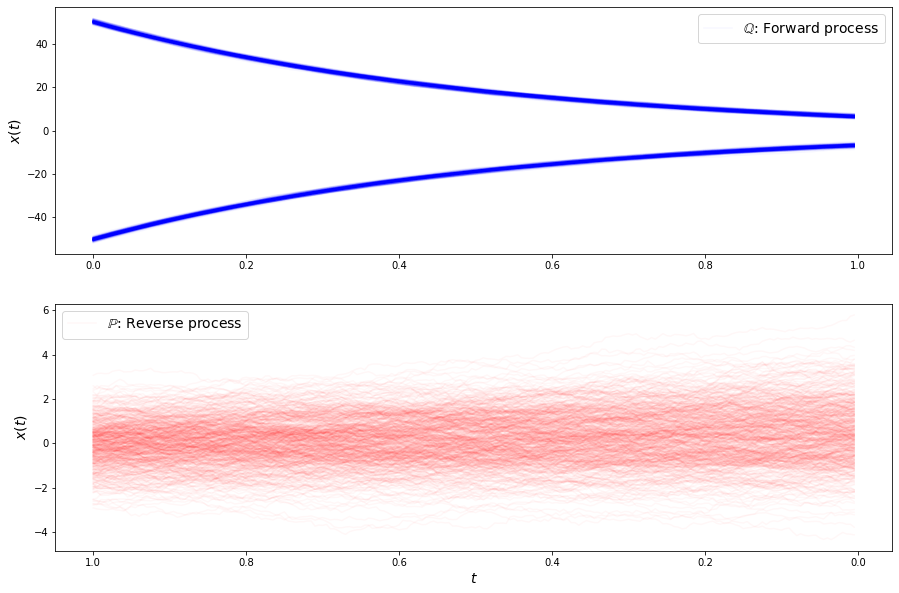

loss b 16.529077529907227
loss b 16.82775115966797
loss b 16.901575088500977
loss f 1243.413330078125
loss f 1238.428955078125
loss f 1242.6590576171875


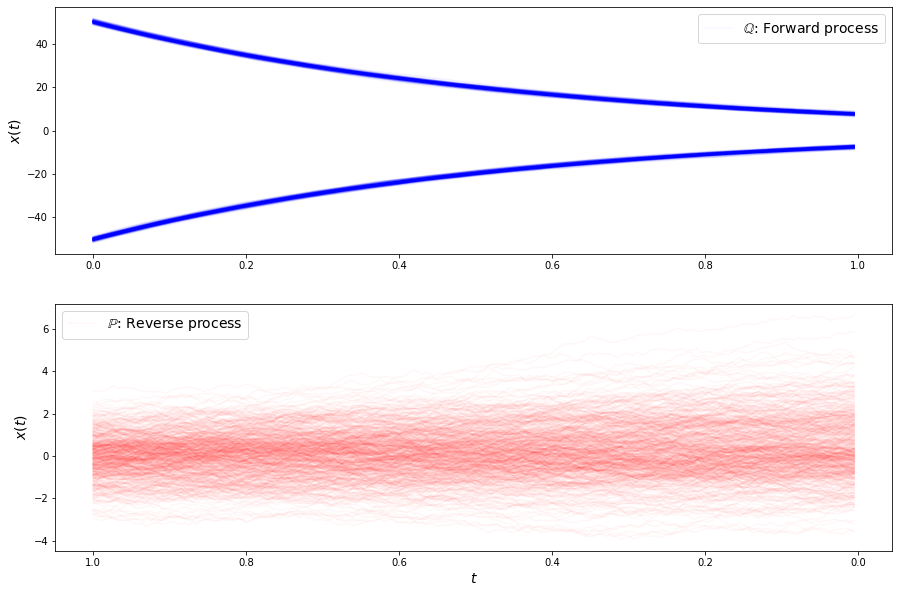

loss b 16.17021942138672
loss b 16.063720703125
loss b 16.192466735839844
loss f 1154.4049072265625
loss f 1154.5001220703125
loss f 1153.985595703125


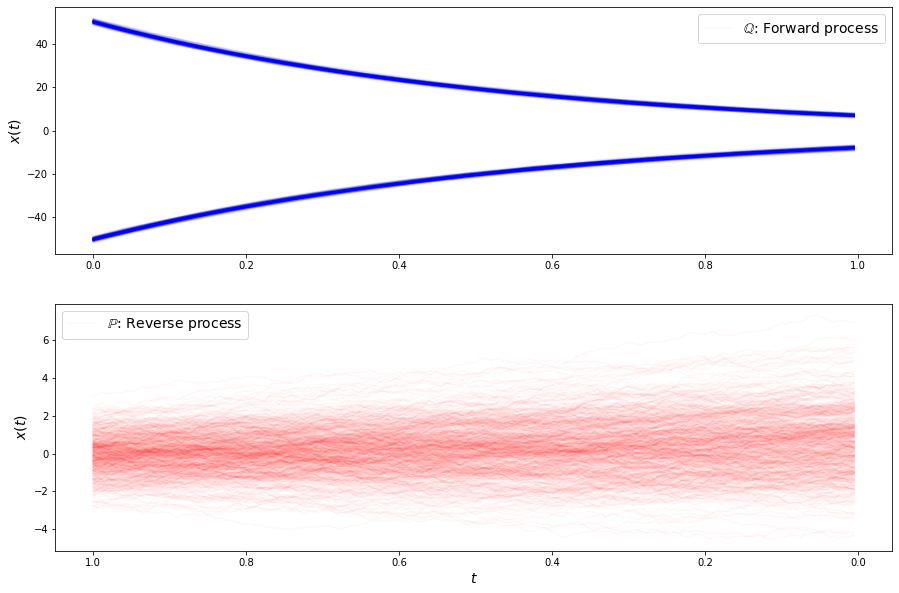

loss b 16.252178192138672
loss b 16.1285400390625
loss b 16.030885696411133
loss f 989.4268188476562
loss f 991.3424682617188
loss f 991.5955200195312


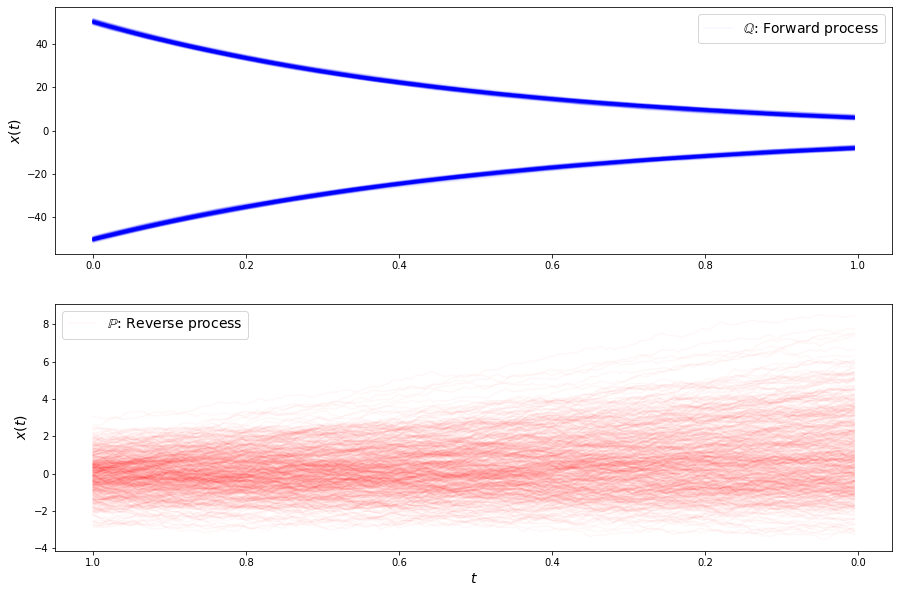

loss b 16.315275192260742
loss b 15.544405937194824
loss b 14.160914421081543
loss f 790.4384155273438
loss f 786.1549682617188
loss f 785.4599609375


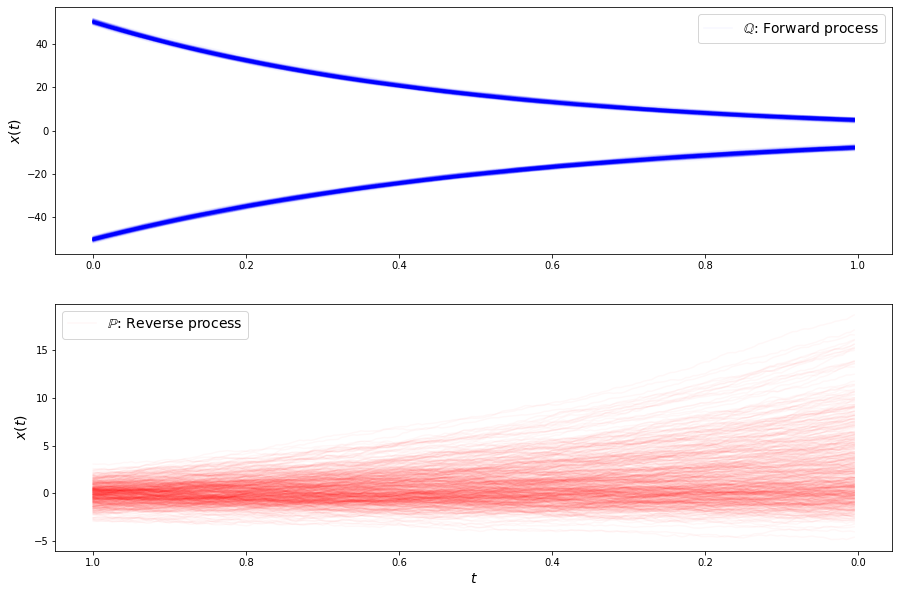

loss b 12.63166618347168
loss b 11.738295555114746
loss b 13.782801628112793
loss f 743.7007446289062
loss f 728.9194946289062
loss f 734.2982177734375


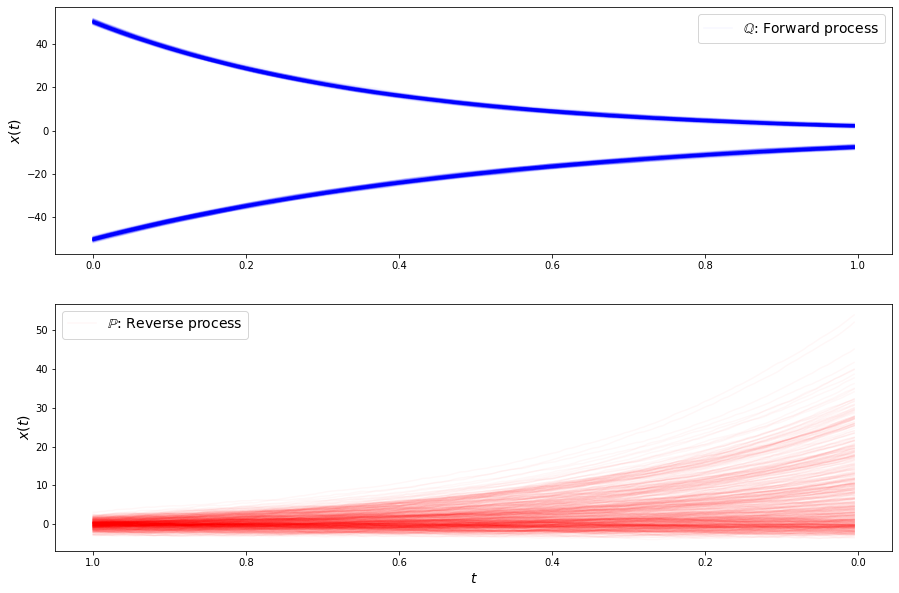

loss b 14.25784969329834
loss b 10.098484992980957
loss b 10.109288215637207
loss f 738.311767578125
loss f 748.69873046875
loss f 750.6853637695312


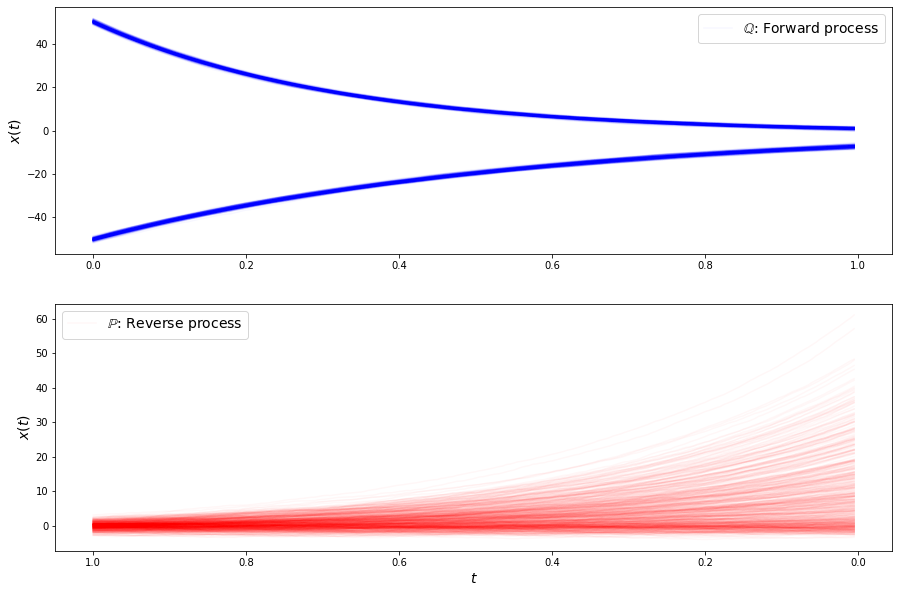

loss b 19.009248733520508
loss b 16.94143295288086
loss b 13.479072570800781
loss f 744.0512084960938
loss f 748.5183715820312
loss f 747.2987060546875


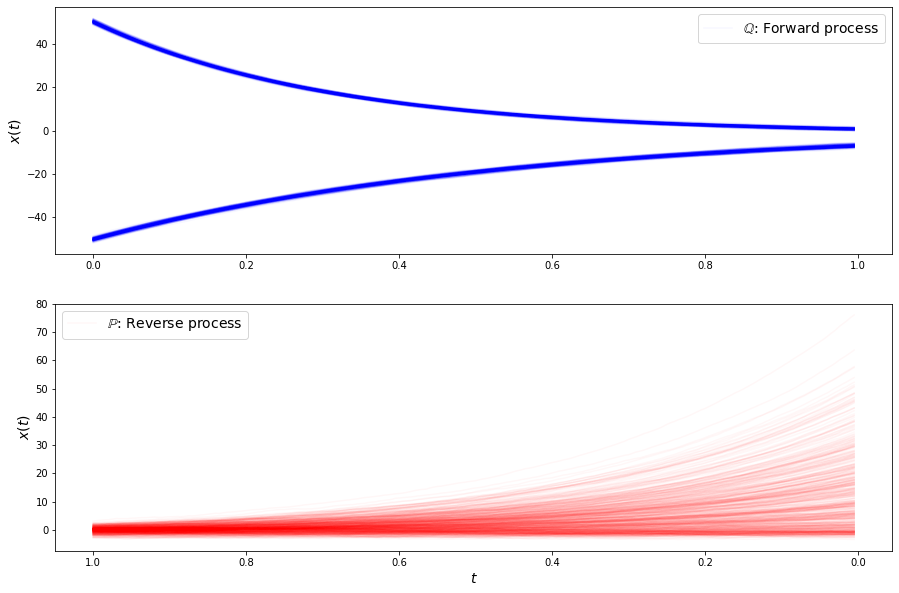

loss b 8.24206256866455
loss b 19.554079055786133
loss b 9.58209228515625
loss f 742.1990966796875
loss f 743.1680297851562
loss f 740.3609008789062


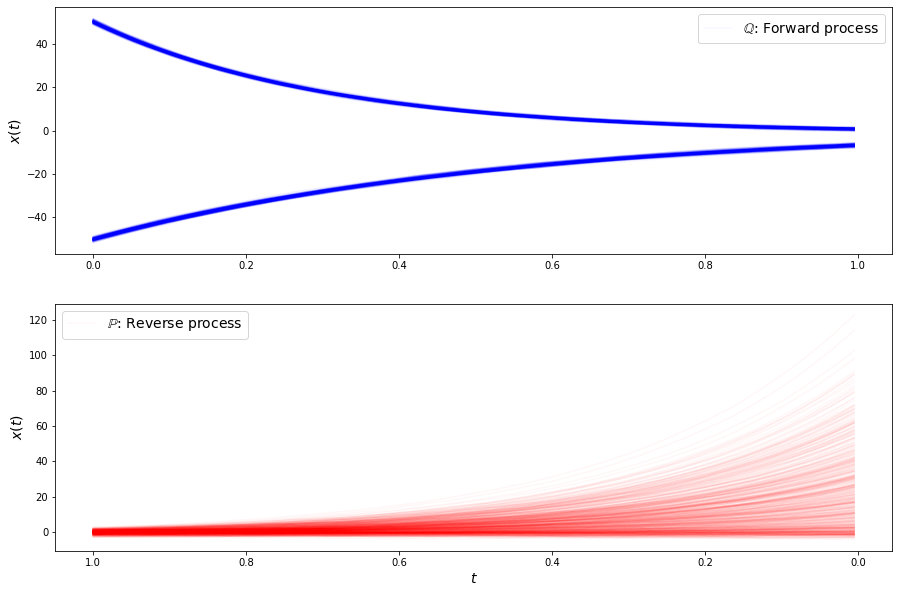

loss b 10.21597671508789
loss b 13.397452354431152
loss b 13.960930824279785
loss f 748.1019287109375
loss f 743.0947875976562
loss f 742.4939575195312


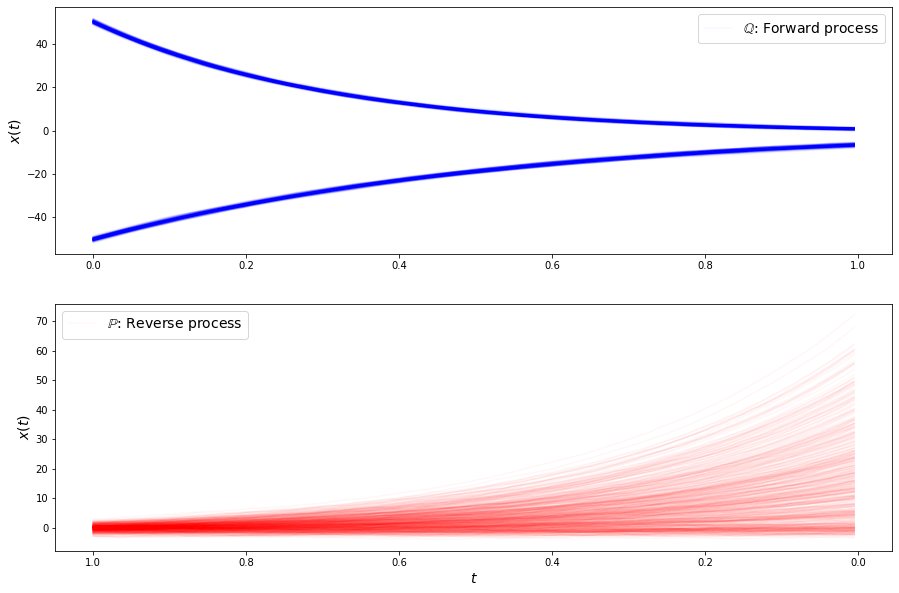

loss b 10.849712371826172
loss b 8.910150527954102
loss b 7.31960391998291
loss f 744.5076293945312
loss f 742.7655639648438
loss f 744.8767700195312


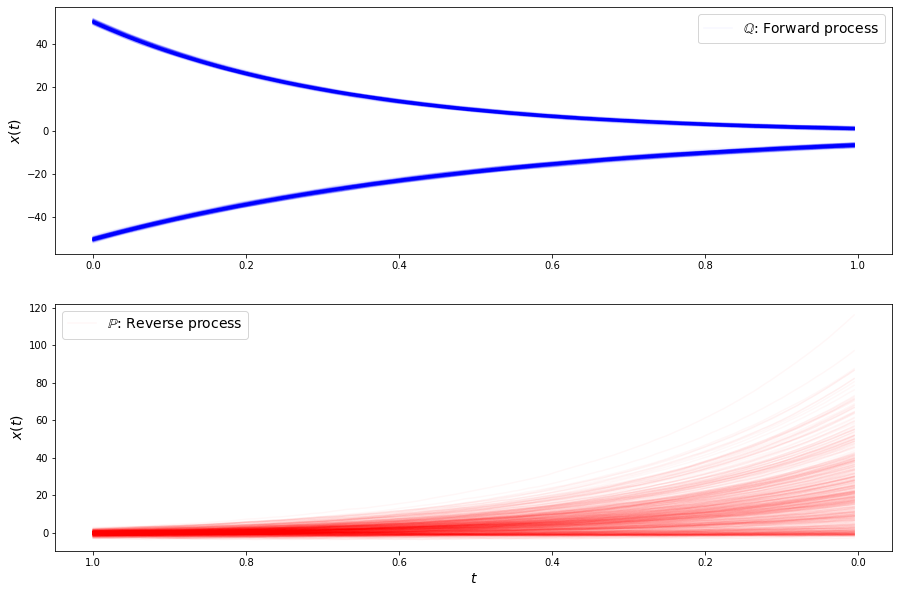

loss b 10.959717750549316
loss b 9.3389253616333
loss b 6.966411113739014
loss f 761.1006469726562
loss f 759.1918334960938
loss f 757.4257202148438


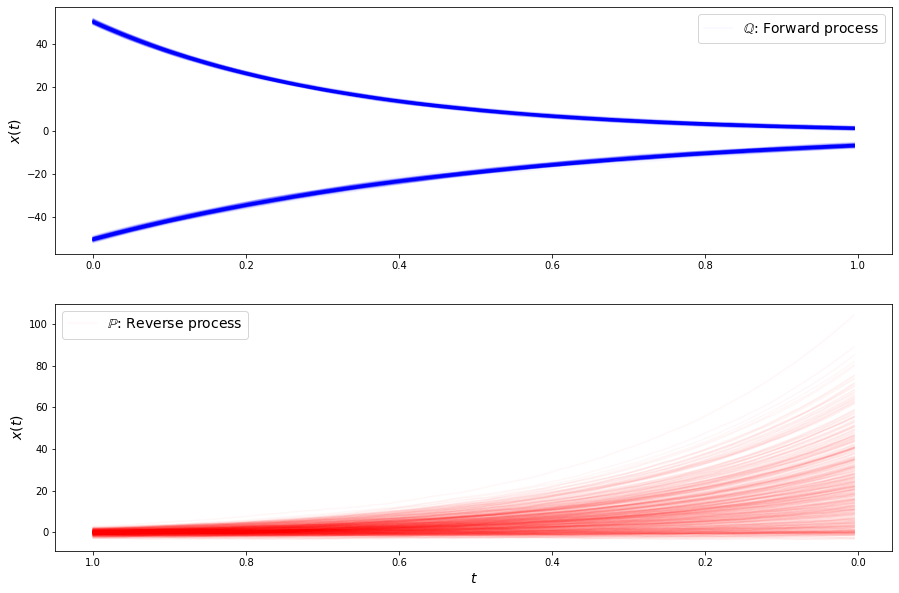

loss b 7.163600921630859
loss b 8.40303897857666
loss b 8.779828071594238
loss f 778.6107788085938
loss f 779.9063110351562
loss f 781.5603637695312


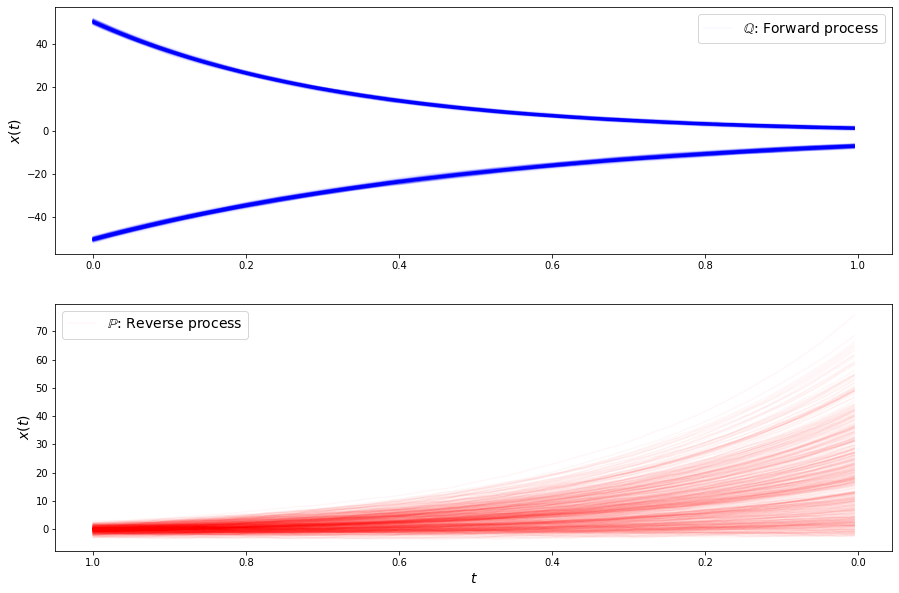

loss b 7.532439231872559
loss b 6.7976393699646
loss b 6.224489212036133
loss f 806.6363525390625
loss f 810.355712890625
loss f 809.40185546875


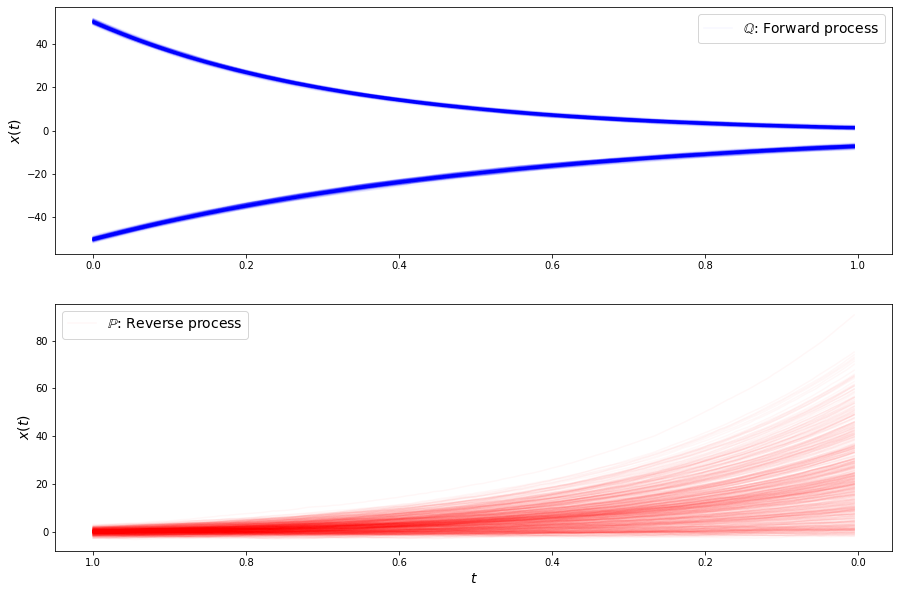

loss b 7.056210994720459
loss b 6.8026251792907715
loss b 6.553433895111084
loss f 856.3040771484375
loss f 854.0108642578125
loss f 859.1137084960938


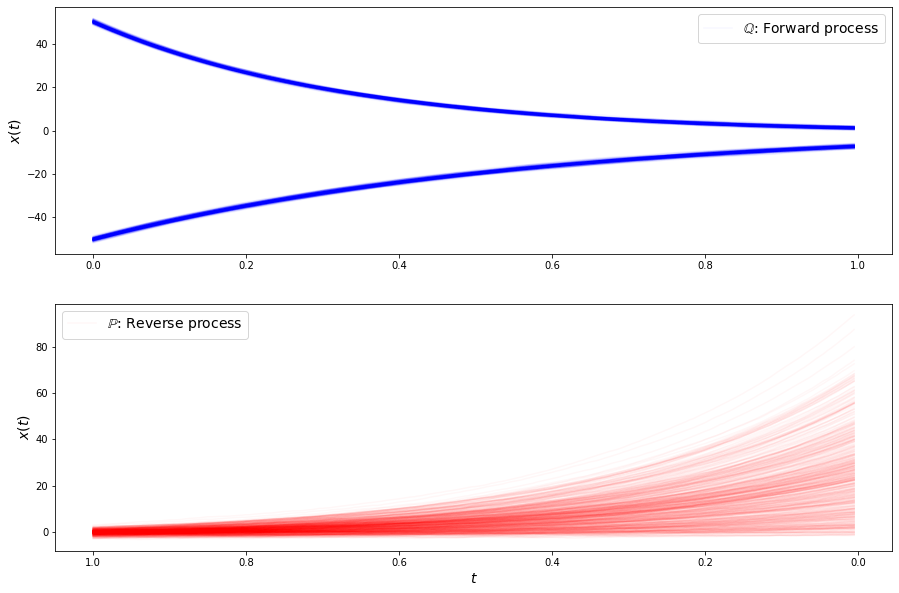

loss b 6.167713165283203
loss b 6.373435020446777
loss b 6.329542636871338
loss f 939.0795288085938
loss f 937.52001953125
loss f 937.1773071289062


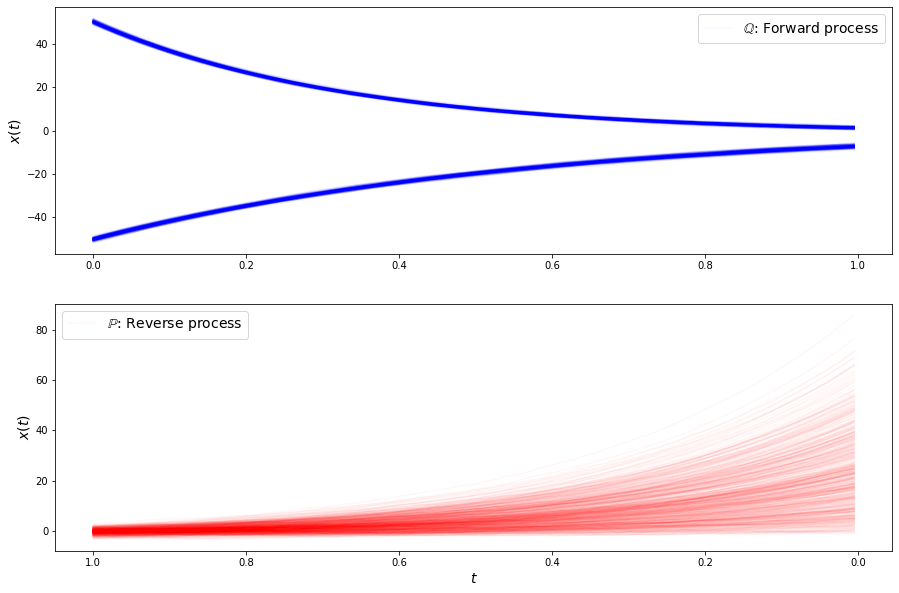

loss b 6.0703325271606445
loss b 5.811563968658447
loss b 5.7964019775390625
loss f 1082.6201171875
loss f 1087.86279296875
loss f 1082.7960205078125


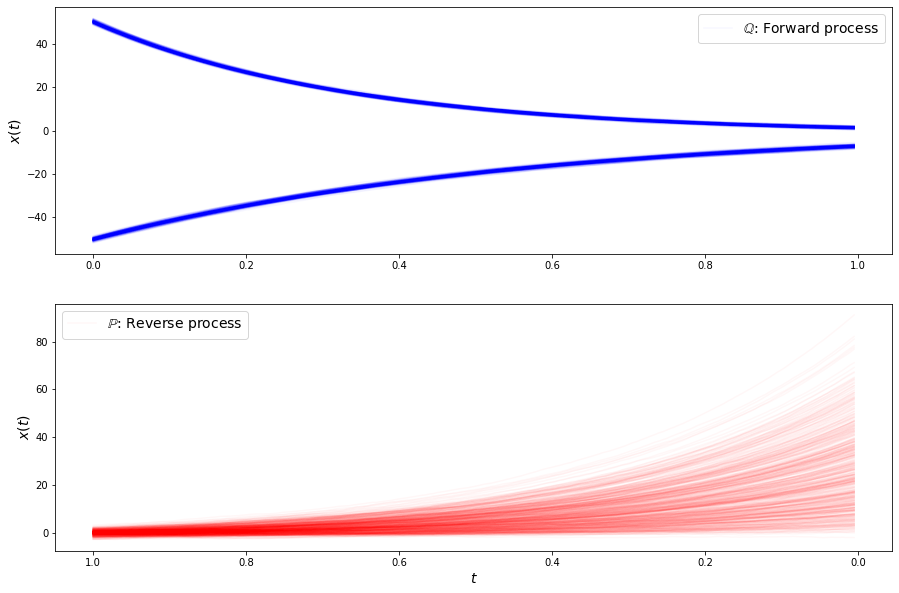

loss b 6.067488670349121
loss b 6.043928623199463
loss b 6.053455352783203
loss f 1288.09521484375
loss f 1285.0673828125
loss f 1287.2293701171875


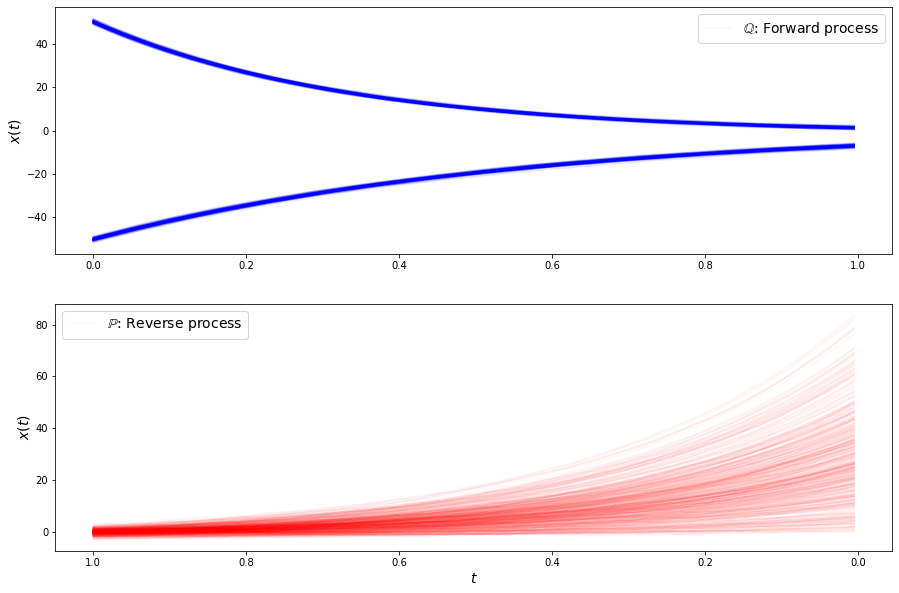

loss b 5.825984477996826
loss b 5.726167678833008
loss b 5.856197357177734
loss f 1488.3919677734375
loss f 1489.185546875
loss f 1490.303466796875


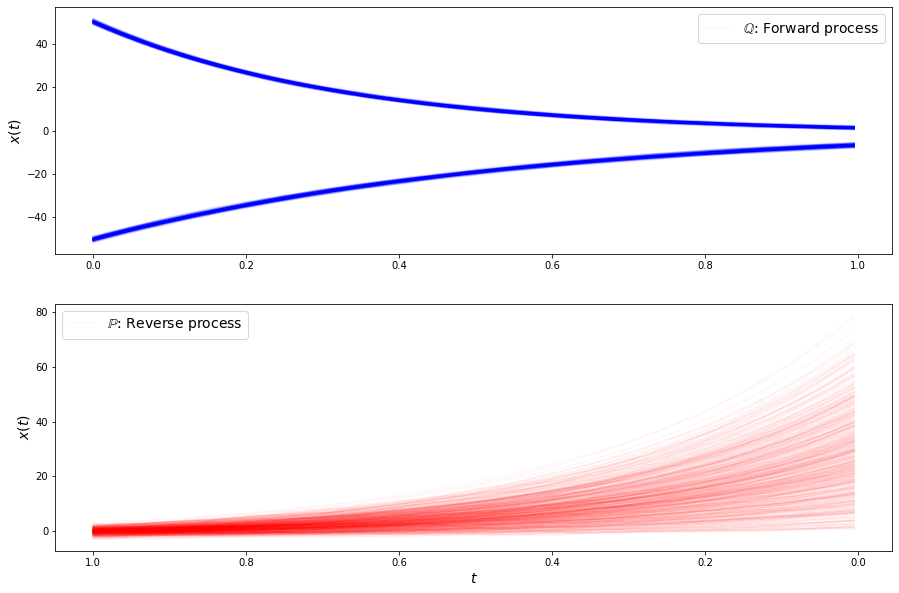

loss b 5.578485012054443
loss b 5.954206466674805
loss b 5.660301208496094
loss f 1716.786376953125
loss f 1722.3077392578125
loss f 1716.5242919921875


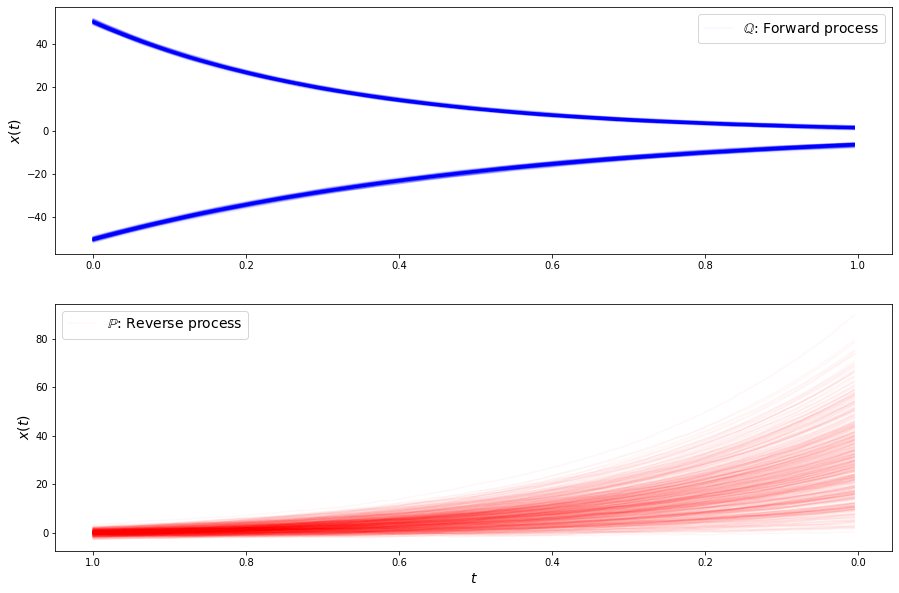

loss b 6.050669193267822
loss b 6.003327369689941
loss b 5.837368965148926
loss f 1943.713134765625
loss f 1942.8819580078125
loss f 1943.5174560546875


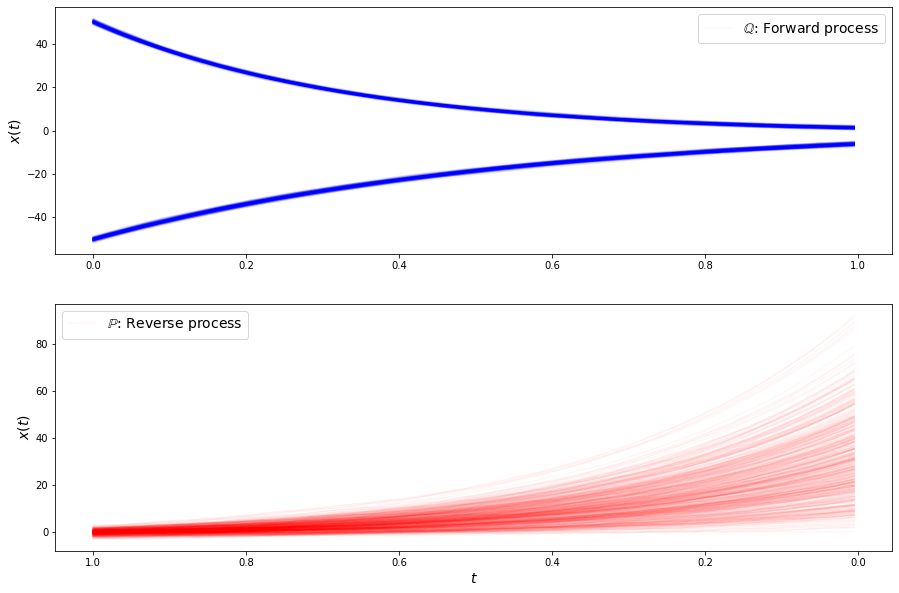

loss b 5.981328010559082
loss b 6.081180095672607
loss b 6.395181179046631
loss f 2145.90380859375


In [ ]:
c.fit(1900, 3, plot=True)

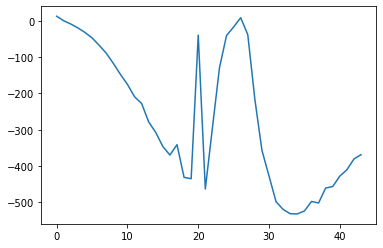

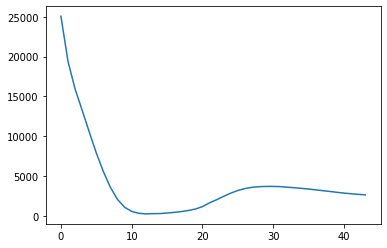

In [11]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

In [12]:
bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)

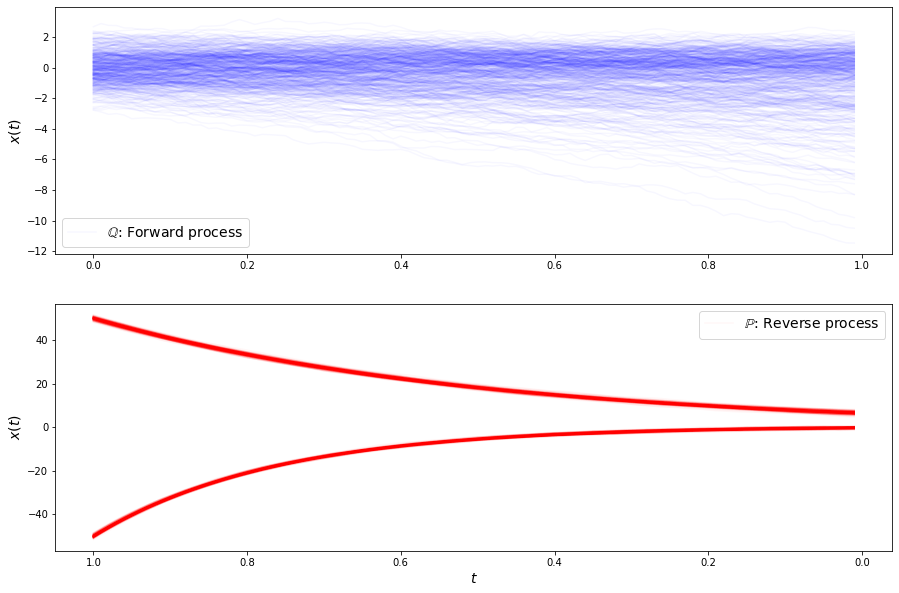

In [13]:
fn = 14
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
axs[1].set_xlabel("$t$", fontsize=fn)
axs[1].set_ylabel("$x(t)$", fontsize=fn)
axs[0].set_ylabel("$x(t)$", fontsize=fn)

tt = axs[1].get_xticks()
axs[1].set_xticks(tt.flatten() )
axs[1].set_xticklabels(list(map (lambda x: '{0:.1f}'.format((x)), tt))[::-1])

for i in range(n):
    label = "$\mathbb{Q}$: Forward process" if i == 0 else None
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03,  label=label)


for i in range(n):
    label = "$\mathbb{P}$: Reverse process" if i == 0 else None
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03, label=label)
    
axs[1].legend(fontsize=fn)
axs[0].legend(fontsize=fn)

plt.savefig("pig_0")

In [38]:
list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1]

['0.00', '0.20', '0.40', '0.60', '0.80', '1.00']

In [ ]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [ ]:
batch_terminal_empirical_b = next(c.data_stream(False))

In [ ]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")

In [ ]:
    def plot_trajectories(self):
        bb = lambda X, theta: -self.b_backward(X, theta)
        t, Xts = c.sde_solver(
            X0=self.X1,dt=self.dt,  theta=self.theta_f,
            beta=self.sigma, alfa=self.b_forward, N=self.number_time_steps
        )
        t_, Xts_ = c.sde_solver(
            X0=self.X2, dt=self.dt,  theta=self.theta_b,
            beta=self.sigma, alfa=bb, N=self.number_time_steps
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.1f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    